In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram

# Описание задачи

Сегментация клиентов немецкого банка при помощи разных методов кластерного анализа.

Загрузим датасет и ознакомимся с ним. Исходный датасет взят с сайта Kaggle: https://www.kaggle.com/datasets/uciml/german-credit

In [2]:
data = pd.read_csv('german_credit_data.csv', sep=',', decimal='.', encoding='CP1251')
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


# Описание столбцов
- Age - Возраст клиента.
- Sex - Пол клиента.
- Job - Оценка квалификации клиента/его резидентства.
- Housing - Тип проживания клиента (в собственности, в аренде).
- Saving accounts - Тип имеющихся депозитов у клиента.
- Checking account - Текущий счет клиента.
- Credit amount - Сумма кредита.
- Duration - Срок кредита.
- Purpose - Цель кредита.

Сразу удалим столбец Unnamed:0, так как это дубляж индекса.

In [3]:
data = data.drop('Unnamed: 0', axis=1)
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


## EDA & Preprocessing

Перед началом моделирования проведем первичный анализ данных. Также преобразуем категориальные переменные.

Посмотрим на типы данных в нашем датасете. И проверим есть ли пропуски в данных.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [5]:
data.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

Как мы видим, пропуски в данных есть по двум факторам Saving accounts и Checking account. Это означает, что по клиентам, которые хотят взять кредит, нет имеющихся счетов в банке. В связи с этим, преобразуем пропуски в No.
Также мы видим, что около половины признаков являются категориальными. Их необходимо преобразовать. 
Для начала преобразуем пустоты в факторах Saving accounts и Checking account.

In [6]:
data['Saving accounts'] = data['Saving accounts'].fillna('No')
data['Checking account'] = data['Checking account'].fillna('No')

## Подготовим данные для анализа:
- Преобразуем категориальные переменные в dummy.
- Переменную Job также преобразуем в dummy переменную, так как эта переменная характеризует квалификацию клиента.
- С помощью стандартизации приведем наши числовые к одному масштабу, так как они измеряются в разных метриках (годы, месяцы, рубли)
- Исключим ненужные переменные.

Для начала преобразуем переменную Job в строку.

In [7]:
data['Job'] = data['Job'].astype(str)

Запишем функцию для преобразования наших данных.

In [8]:
def data_preprocessing(data, cols_for_dummy, cols_for_scaler, cols_for_drop):
    #Преобразование в dummy
    data_dumm = pd.get_dummies(data[cols_for_dummy], prefix=cols_for_dummy, prefix_sep='=')
    data = pd.concat([data, data_dumm], axis=1)
    
    #Стандартизация числовых данных
    scaler = StandardScaler()
    data[cols_for_scaler] = scaler.fit_transform(data[cols_for_scaler])
    
    #Удаление переменных
    data = data.drop(cols_for_drop, axis=1)
    
    return data

In [9]:
data_preproc = data_preprocessing(data,
                                 cols_for_dummy=['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'],
                                 cols_for_scaler=['Age', 'Credit amount', 'Duration'],
                                 cols_for_drop=['Housing', 'Purpose', 'Sex', 'Saving accounts', 'Checking account', 'Job'])
data_preproc.head()

,Age,Credit amount,Duration,Sex=female,Sex=male,Job=0,Job=1,Job=2,Job=3,Housing=free,...,Checking account=moderate,Checking account=rich,Purpose=business,Purpose=car,Purpose=domestic appliances,Purpose=education,Purpose=furniture/equipment,Purpose=radio/TV,Purpose=repairs,Purpose=vacation/others
0,2.766456,-0.745131,-1.236478,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,-1.191404,0.949817,2.248194,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
2,1.183312,-0.416562,-0.738668,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.831502,1.634247,1.750384,0,1,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
4,1.535122,0.566664,0.256953,0,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0


Для дальнейшего анализа стоит исключить переменную Sex=female, так как она не несет смысловую нагрузку, и нам будет достаточно ориентироваться только на один флаг Sex=male.
Стоит отметить, что по остальным полученным переменным из категорий, там важно использование каждой категории, так как их несколько, и каждая может сыграть по своемому в модели.

Преобразуем данные касательно пола клиента.

In [10]:
data_preproc = data_preproc.drop('Sex=female', axis=1)
data_preproc = data_preproc.rename({'Sex=male' : 'Sex'}, axis=1)
data_preproc.head()

,Age,Credit amount,Duration,Sex,Job=0,Job=1,Job=2,Job=3,Housing=free,Housing=own,...,Checking account=moderate,Checking account=rich,Purpose=business,Purpose=car,Purpose=domestic appliances,Purpose=education,Purpose=furniture/equipment,Purpose=radio/TV,Purpose=repairs,Purpose=vacation/others
0,2.766456,-0.745131,-1.236478,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,-1.191404,0.949817,2.248194,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,1.183312,-0.416562,-0.738668,1,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0.831502,1.634247,1.750384,1,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,1.535122,0.566664,0.256953,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0


## Снижение размерности
Так как в результате обработки датасета, на выходе мы получили большое количество переменных, имеет смысл снизить размерность наших данных. Будем делать это с помощью PCA.

In [11]:
X = data_preproc.values
X

array([[ 2.76645648, -0.74513141, -1.23647786, ...,  1.        ,
         0.        ,  0.        ],
       [-1.19140394,  0.94981679,  2.24819436, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.18331231, -0.41656241, -0.73866754, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.21583532, -0.87450324, -0.73866754, ...,  1.        ,
         0.        ,  0.        ],
       [-1.10345149, -0.50552769,  1.9992892 , ...,  1.        ,
         0.        ,  0.        ],
       [-0.75164167,  0.46245715,  1.9992892 , ...,  0.        ,
         0.        ,  0.        ]])

In [12]:
pca = PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Теперь посмотрим на объясненную дисперсию и построим график.

In [13]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)
explained_variance

array([0.26707609, 0.43546496, 0.50912423, 0.57512726, 0.63068243,
       0.6800568 , 0.7252506 , 0.76861421, 0.80342029, 0.83658351,
       0.86658713, 0.89015521, 0.91055317, 0.92813345, 0.94502773,
       0.95740161, 0.96905899, 0.97910015, 0.98736941, 0.99205157,
       0.99591031, 0.99820296, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ])

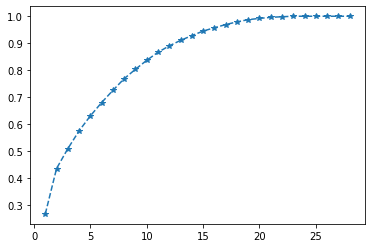

In [14]:
plt.plot(range(1, len(explained_variance) + 1), explained_variance, '*--');

Как мы видим из графика и массива выше, порядка 95% объясненной дисперсии приходится на 15 компонент. Таким образом, мы сможем снизить размерность наших данных почти в 2 раза. 

Преобразуем наши данные.

In [15]:
X_reduced = PCA(n_components=15).fit_transform(X)

## Построение кластерного анализа K-means

Построим кластерный анализ с использованием метода K-means. Для начала определимся с оптимальным количеством кластеров. Воспользуемся для этого методом Elbow method.

In [16]:
k_max = 10

inertia = []
for k in range(1, k_max):

    kmeans = KMeans(n_clusters=k).fit(X_reduced)
    
    inertia.append(np.sqrt(kmeans.inertia_))

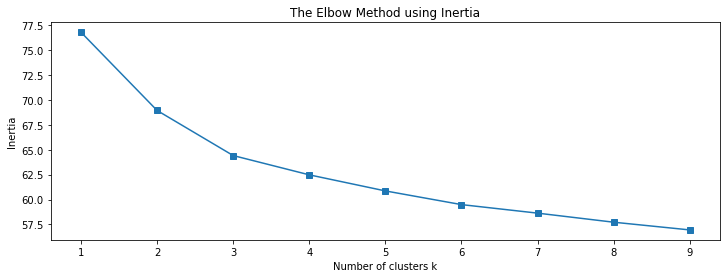

In [17]:
plt.figure(figsize=(12, 4))
plt.plot(range(1, k_max), inertia, marker='s')

plt.title('The Elbow Method using Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')

plt.show()

In [18]:
d = {}
for k in range(2, k_max-1):
    i = k - 1
    d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])

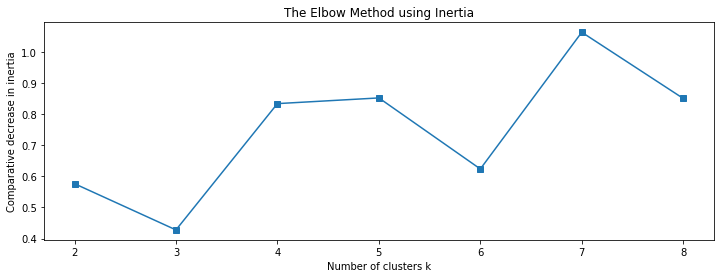

In [19]:
plt.figure(figsize=(12, 4))
plt.plot(range(2, k_max-1), [x for x in d.values()], marker='s')

plt.title('The Elbow Method using Inertia')
plt.xlabel('Number of clusters k')
plt.ylabel('Comparative decrease in inertia')

plt.show()

Как мы видим из построенных выше графиков, оптимальное количество кластеров для наших данных достигается при 3 кластерах (именно при этом значении индекс инерции начинает убывать).
Построим K-means для 3 кластеров.

In [20]:
kmeans = KMeans(n_clusters=3).fit(X_reduced)

Преобразуем полученные лейблы по кластерам для подцепки к исходным данным.

In [21]:
kmeans_labels = pd.DataFrame(kmeans.labels_)
kmeans_labels = kmeans_labels.rename({0 : 'kmeans_classes'}, axis=1)
kmeans_labels.head()

,kmeans_classes
0,2
1,1
2,2
3,1
4,2


## Интерпретация кластеров K-means
Проинтерпретируем полученные кластеры при помощи метода K-means. Подсоединим значения классов к исходному датасету.
Для удобства интерпретации преобразуем наши кластеры (прибавим к ним 1).

In [22]:
data_with_classes = pd.concat((data, kmeans_labels), axis=1)
data_with_classes['kmeans_classes'] = data_with_classes['kmeans_classes'] + 1
data_with_classes['count'] = 1
data_with_classes.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,kmeans_classes,count
0,67,male,2,own,No,little,1169,6,radio/TV,3,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,2,1
2,49,male,1,own,little,No,2096,12,education,3,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,2,1
4,53,male,2,free,little,little,4870,24,car,3,1


Для более наглядной интерпретации результатов построим боксплоты. Построим боксплот по возрасту в разбивке на пол.

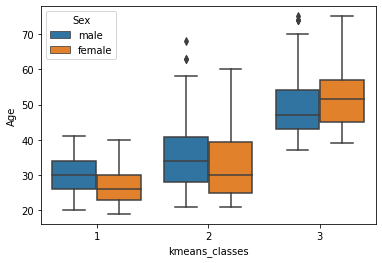

In [23]:
sns.boxplot(x='kmeans_classes', y='Age', hue='Sex', data=data_with_classes)

Как мы видим, в 3 кластере сосредоточены более возрастные клиенты. В 1 кластере сосредоточены более молодые клиенты, но в целом видно, что данные клиенты несильно моложе клиентов из 2 кластера.

Построим боксплоты в зависимости от срока кредита.

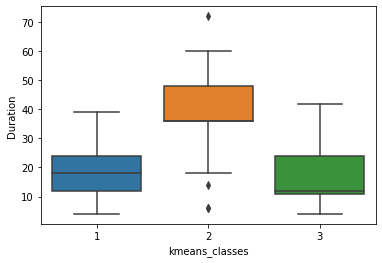

In [24]:
sns.boxplot(x='kmeans_classes', y='Duration', data=data_with_classes)

Из построенных графиков видно, что клиенты 1 и 3 кластера берут кредит на примерно схожие сроки кредита, но в среднем клиенты из 3 кластера на более меньший срок. В то время, как клиенты 2 кластера берут кредит на долгий срок.

Построим боксплоты в зависимости от величины кредита.

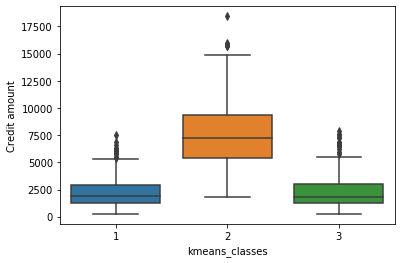

In [25]:
sns.boxplot(x='kmeans_classes', y='Credit amount', data=data_with_classes)

По сути полученный график взаимосвязан с прошлым графиком. Мы видим, что клиенты 2 кластера берут большую сумму кредита, что подтверждается прошлым графиком (2 кластер = больший срок). В то время, как клиенты 1 и 3 кластера берут кредиты на меньшую сумму кредита.

А теперь посмотрим, на что клиенты каждого кластера собираются брать кредиты. Построим таблицу по долям.

In [26]:
data_purpose = pd.pivot_table(data_with_classes, index='kmeans_classes', columns='Purpose', values='count', aggfunc=np.sum)
data_purpose['count'] = 0
for i in data_purpose.columns[: -1]:
    data_purpose['count'] += data_purpose[i]
data_purpose.head()

Purpose,business,car,domestic appliances,education,furniture/equipment,radio/TV,repairs,vacation/others,count
kmeans_classes,,,,,,,,,
1,50,163,8,24,127,171,12,1,556
2,31,79,2,12,20,35,1,8,188
3,16,95,2,23,34,74,9,3,256


Рассчитаем долю в каждом разрезе

In [27]:
data_purpose = data_purpose.apply(lambda x: round((x / data_purpose['count']) * 100, 2))
data_purpose

Purpose,business,car,domestic appliances,education,furniture/equipment,radio/TV,repairs,vacation/others,count
kmeans_classes,,,,,,,,,
1,8.99,29.32,1.44,4.32,22.84,30.76,2.16,0.18,100.0
2,16.49,42.02,1.06,6.38,10.64,18.62,0.53,4.26,100.0
3,6.25,37.11,0.78,8.98,13.28,28.91,3.52,1.17,100.0


Из таблицы выше, мы видим, что клиенты 2 кластера чаще других рассматривают своей целью кредит на бизнес, автомобиль и отпуск (и прочие цели). При этом практически не рассматривают кредит на ремонт.
Клиенты 3 кластера чаще других расматривают кредит на обучение, ремонт. В меньшей степени рассматривают кредит на бытовую технику.
Клиенты 1 кластера чаще других рассматривают кредит на покупку мебели/оборудование и на телекоммуникацию.


### Описание кластеров
По итогу анализа отдельного фактора в каждом кластера, мы можем описать кластеры:
- 1 кластер - В этом кластере сосредоточены самые молодые клиенты (средний возраст до 30 лет). Они, как и клиенты из 2 кластера, рассматривают кредит на небольшой срок и небольшую сумму кредита. В качестве целей кредита, они рассматривают кредиты на мебель, бытовую технику и телекоммуникацию.
- 2 кластер - В этом кластере сосредоточены люди более возрастные люди (старше 40 лет), которые берут кредит на небольшой срок под небольшую сумму кредита. В качестве целей кредита, в сравнении с другими клиентами, чаще рассматривают кредиты на обучение, ремонт.
- 3 кластер - В этом кластере сосредоточены клиенты средневозрастного возраст (средний возраст 35 лет). Данные клиенты берут кредит на большой срок и на большую сумму кредита. Это объясняется и целями их кредита. Они чаще других берут кредит на бизнес и автомобиль.

## Построение кластерного анализа на аггломеротивной кластеризации
Построим иерархическую аггломеративную кластеризацию. Запишем функцию для строительства дендограммы.

In [28]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Построим дендограмму и определим оптимальный порог по расстоянию для определения оптимального количества кластеров.

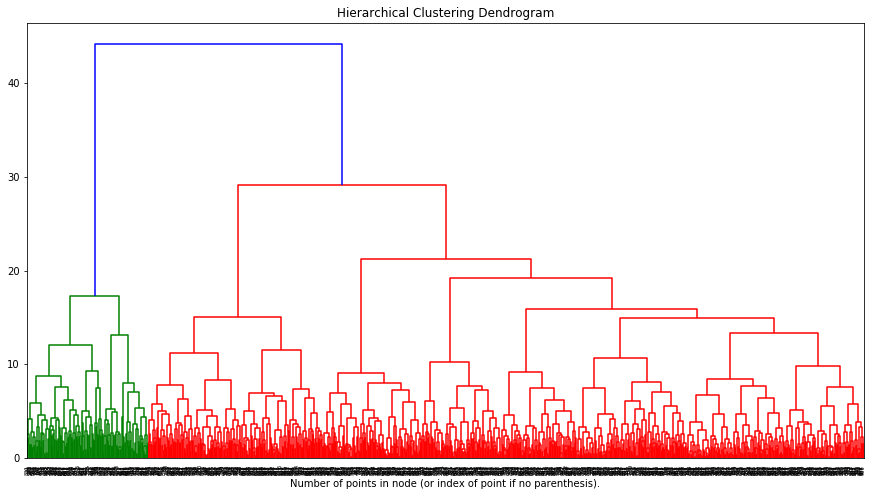

In [29]:
ac = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
ac = ac.fit(X_reduced)

plt.figure(figsize=(15, 8))
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(ac)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Как мы видим из полученной дендограммы, при низких порогах значения расстояния мы будем получать большое количество кластеров, что сложно для интерпретации. Видно, что при пороговом значении большем 20 и меньшем 30, мы получим 3 кластера. Также сразу можно сделать вывод, что самый правый кластер наиболее многочисленный с точки зрения объектов.

Запустим заново алгоритм кластеризации с учетом заданного порогового значения расстояния.

In [30]:
ac = AgglomerativeClustering(n_clusters=None, distance_threshold=25)
ac_labels = pd.DataFrame(ac.fit_predict(X_reduced))
ac_labels = ac_labels.rename({0 : 'agglomer_classes'}, axis=1)
ac_labels.head()

,agglomer_classes
0,2
1,0
2,0
3,1
4,2


## Интерпретация кластеров на основе иерархии
Проинтерпретируем полученные кластеры при помощи аггломеративной кластеризации. Подсоединим значения классов к исходному датасету.
Для удобства интерпретации преобразуем наши кластеры (прибавим к ним 1).

In [31]:
data_with_classes = pd.concat((data_with_classes, ac_labels), axis=1)
data_with_classes['agglomer_classes'] = data_with_classes['agglomer_classes'] + 1
data_with_classes.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,kmeans_classes,count,agglomer_classes
0,67,male,2,own,No,little,1169,6,radio/TV,3,1,3
1,22,female,2,own,little,moderate,5951,48,radio/TV,2,1,1
2,49,male,1,own,little,No,2096,12,education,3,1,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,2,1,2
4,53,male,2,free,little,little,4870,24,car,3,1,3


Для более наглядной интерпретации результатов построим боксплоты. Построим боксплот по возрасту в разбивке на пол.

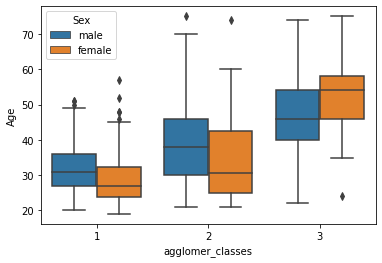

In [32]:
sns.boxplot(x='agglomer_classes', y='Age', hue='Sex', data=data_with_classes)

Как мы видим, в 3 кластере сосредоточены более возрастные клиенты. В 1 кластере сосредоточены более молодые клиенты, но в целом видно, что данные клиенты несильно моложе клиентов из 2 кластера.

Построим боксплоты в зависимости от срока кредита.

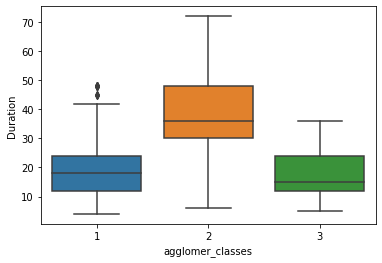

In [33]:
sns.boxplot(x='agglomer_classes', y='Duration', data=data_with_classes)

Из построенных графиков видно, что клиенты 1 и 3 кластера берут кредит на примерно схожие сроки кредита, но в среднем клиенты из 3 кластера на более меньший срок. В то время, как клиенты 2 кластера берут кредит на долгий срок.

Построим боксплоты в зависимости от величины кредита.

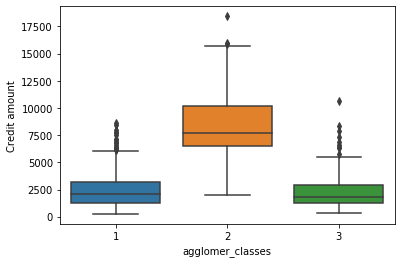

In [34]:
sns.boxplot(x='agglomer_classes', y='Credit amount', data=data_with_classes)

По сути полученный график взаимосвязан с прошлым графиком. Мы видим, что клиенты 2 кластера берут большую сумму кредита, что подтверждается прошлым графиком (2 кластер = больший срок). В то время, как клиенты 1 и 3 кластера берут кредиты на меньшую сумму кредита.

А теперь посмотрим, на что клиенты каждого кластера собираются брать кредиты. Построим таблицу по долям.

In [35]:
data_purpose = pd.pivot_table(data_with_classes, index='agglomer_classes', columns='Purpose', values='count', aggfunc=np.sum)
data_purpose['count'] = 0
for i in data_purpose.columns[: -1]:
    data_purpose['count'] += data_purpose[i]
data_purpose.head()

Purpose,business,car,domestic appliances,education,furniture/equipment,radio/TV,repairs,vacation/others,count
agglomer_classes,,,,,,,,,
1,59,200,9,31,126,205,14,2,646
2,27,74,1,10,9,15,2,7,145
3,11,63,2,18,46,60,6,3,209


Рассчитаем долю в каждом разрезе.

In [36]:
data_purpose = data_purpose.apply(lambda x: round((x / data_purpose['count']) * 100, 2))
data_purpose

Purpose,business,car,domestic appliances,education,furniture/equipment,radio/TV,repairs,vacation/others,count
agglomer_classes,,,,,,,,,
1,9.13,30.96,1.39,4.80,19.50,31.73,2.17,0.31,100.0
2,18.62,51.03,0.69,6.90,6.21,10.34,1.38,4.83,100.0
3,5.26,30.14,0.96,8.61,22.01,28.71,2.87,1.44,100.0


Из таблицы выше, мы видим, что клиенты 2 кластера чаще других рассматривают своей целью кредит на бизнес, автомобиль и отпуск (и прочие цели). При этом практически не рассматривают кредит на ремонт.
Клиенты 1 кластера чаще других рассматривают кредит на телекоммункацию и бытовую технику.
Клиенты 3 кластера чаще других расматривают кредит на обучение, мебель и ремонт.


### Описание кластеров
По итогу анализа отдельного фактора в каждом кластера, мы можем описать кластеры:
- 1 кластер - В этом кластере сосредоточены самые молодые клиенты. Они, как и клиенты из 3 кластера, рассматривают кредит на небольшой срок и небольшую сумму кредита. В качестве целей кредита, они рассматривают кредиты на бытовую технику и телекоммуникацию.
- 2 кластер - В этом кластере сосредоточены клиенты средневозрастного возраст. Данные клиенты берут кредит на большой срок и на большую сумму кредита. Это объясняется и целями их кредита. Они чаще других берут кредит на бизнес и автомобиль.
- 3 кластер - В этом кластере сосредоточены люди более возрастные люди, которые берут кредит на небольшой срок под небольшую сумму кредита. В качестве целей кредита, в сравнении с другими клиентами, чаще рассматривают кредиты на обучение, ремонт.

## Общий вывод по итогу двух методов.
Как мы видим, по итогу кластерного анализа методом Kmeans и аггломеративной кластеризации, мы получили схожие по структуре кластеры.

# Кластеризация методом DBSCAN
Построим кластерный анализ при помощи метода DBSCAN. Для начала определимся с оптимальным гиперпараметром EPS.
Для этого  построим график с k-расстояниями на основе метода ближайших соседей. И найдем точку перегиба.

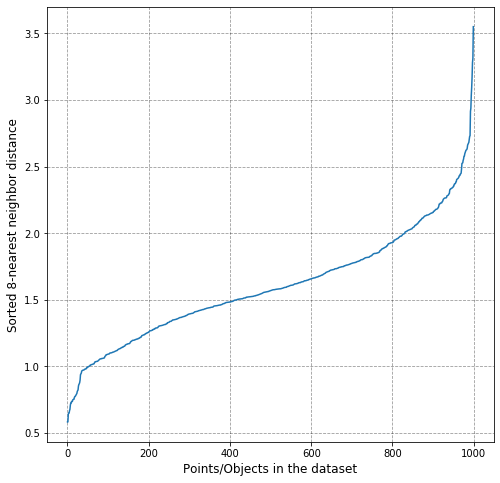

In [37]:
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()

get_kdist_plot(X=X_reduced, k=k)

Как мы видим, точка перегиба находится на уровне 2.3.
Запустим строительство модели с использованием min_samples = 30 (т.е. количество компонент * 2).

In [38]:
dbscan = DBSCAN(eps = 2.5, min_samples = 30)

Посмотрим на полученные кластеры

In [40]:
db_labels = pd.DataFrame(dbscan.fit_predict(X_reduced))
db_labels = db_labels.rename({0 : 'db_classes'}, axis=1)
db_labels['db_classes'].value_counts()

 0    978
-1     22
Name: db_classes, dtype: int64

Как мы видим, кластеризация DBSCAN не выявила различия в наших данных. Все клиенты объеденены в один кластер.